In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
%%capture
!rm -rf x86_64
!nrnivmodl ../mechanisms

In [3]:
from neuron import h
h.load_file("stdrun.hoc");

In [4]:
from glob import glob
cellhocs = sorted(glob('Cell_*.hoc'))
cellhocs = cellhocs[:1]
cellhocs

['Cell_0.hoc']

In [5]:
isi = 1.0
nsyn = 10  #7  #10
amp = 0.407
#weight = 0.5e-3 * 4.83/3.13
weight = 0.5e-3 * 4.263/3.118
nmda_ratio = 1.5  #2.0
simtime = 1000
stim_start = simtime / 2
stim_end = stim_start + nsyn*isi

In [6]:
def breadth(sec):
    return len(sec.subtree())

def is_terminal(sec):
    return breadth(sec) == 1

def is_stem(sec):
    return 'soma' in str(sec.parentseg()) and not 'soma' in sec.name()

def get_terminals(sec):
    return [s for s in sec.subtree() if is_terminal(s)]

def get_stems(sec):
    return [s for s in sec.wholetree() if is_stem(s)]

In [7]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.
    
    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = np.array(colorsys.rgb_to_hls(*mc.to_rgb(c)))
    return colorsys.hls_to_rgb(c[0],1-amount * (1-c[1]),c[2])

In [8]:
def make_cell(hoc, morph=None):
    h.load_file(hoc)
    name = hoc.split('.')[0]
    if morph:
        cmd = f'h.{name}("../morphology/", "{morph}")'
    else:
        cmd = f'h.{name}("../morphology/")'  # default morphology
    cell = eval(cmd)
    return cell

In [9]:
def make_nterm_cells(hoc, morph=None):
    cell = make_cell(hoc, morph)
    nterm = len([sec for sec in get_terminals(cell.soma[0]) if 'dend' in sec.name()])
    cells = [make_cell(hoc, morph) for i in range(nterm)]
    return cells

In [10]:
def set_syn_stim_cluster(stimtime, cell, seclist=[], nsyn=10, weight=0.5e-3, nmda_ratio=0.5):
    stimuli = []
    nsts = []
    cons = []
    syns = []
    sections = seclist if seclist else np.random.choice(
        [sec for sec in cell.soma[0].subtree() if 'dend' in sec.name()], 10)

    for sec in sections:
        for i, x in enumerate(np.linspace(0.49, 0.51, nsyn)):
            ns = h.NetStim()
            ns.number = 1
            ns.start = stimtime + i*isi
            syn = h.tmGlut(sec(x))
            syn.nmda_ratio = nmda_ratio
            nc = h.NetCon(ns, syn)
            nc.weight[0] = weight
            cons.append(nc)
            syns.append(syn)
            nsts.append(ns)
            stimuli.append((cons, syns, nsts))
    return stimuli

In [11]:
def set_syn_clustered(stimtime, cells, nsyn=10, weight=0.5e-3, nmda_ratio=0.5):
    synstimuli = []
    for i, cell in enumerate(cells):
        dend_terms = sorted([sec for sec in get_terminals(cell.soma[0]) if 'dend' in sec.name()])
        term = dend_terms[i]
        stimuli = set_syn_stim_cluster(stimtime, cell, [term], nsyn, weight, nmda_ratio)
        synstimuli.append(stimuli)
    return synstimuli

In [12]:
def set_soma_stim(amp, delay, dur, cells):
    stimuli = []
    for cell in cells:
        soma = cell.soma[0]
        stim = h.IClamp(soma(0.5))
        stim.amp = amp
        stim.delay = delay
        stim.dur = dur
        stimuli.append(stim)
    return stimuli

In [13]:
def get_term_volts(cells, x=1.0):
    volts = []
    for i, cell in enumerate(cells):
        dend_tips = sorted([sec for sec in get_terminals(cell.soma[0]) if 'dend' in sec.name()])
        volt = h.Vector()
        volt.record(dend_tips[i](x)._ref_v)
        volts.append(volt)
    return volts

In [14]:
def get_soma_volts(cells):
    volts = []
    for i, cell in enumerate(cells):
        volt = h.Vector()
        volt.record(cell.soma[0](0.5)._ref_v)
        volts.append(volt)
    return volts

In [15]:
allcells = []
for cellhoc in cellhocs:
    allcells.append(make_nterm_cells(cellhoc))
#allcells

In [16]:
allstim = []
for cells in allcells:
    stimuli = set_soma_stim(amp, 0, simtime, cells)
    allstim.append(stimuli)

In [17]:
allsynstim = []
for cells in allcells:
    stimuli = set_syn_clustered(stim_start, cells, nsyn=nsyn, weight=weight, nmda_ratio=nmda_ratio)
    allsynstim.append(stimuli)

In [18]:
allvolts = []
allsoma_volts = []
for cells in allcells:
    volts = get_term_volts(cells, x=0.5)
    soma_volts = get_soma_volts(cells)
    allvolts.append(volts)
    allsoma_volts.append(soma_volts)

In [19]:
time = h.Vector()
time.record(h._ref_t);

In [20]:
%%time
h.v_init = -70  # -92.5
h.celsius = 35
h.tstop = simtime
cvode = h.CVode()
cvode.active(True)
h.run()

CPU times: user 1min 12s, sys: 193 ms, total: 1min 12s
Wall time: 1min 12s


0.0

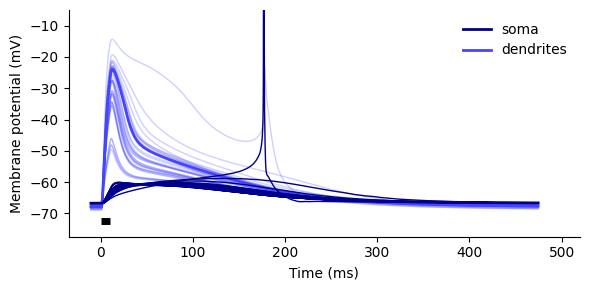

In [21]:
fig, ax = plt.subplots(figsize=(6, 3))

color = 'darkblue'
t = np.array(time)
_label = True
for volts, soma_volts in zip(allvolts, allsoma_volts):
    for volt, soma_volt in zip(volts, soma_volts):
        v = np.array(volt)
        s = np.array(soma_volt)
        sel = (t > stim_start - 50)
        lw = 2 if _label else 1
        label = 'soma' if _label else ''
        ax.plot(t[sel] - stim_start, s[sel], color=color, label=label, linewidth=lw, zorder=100)
        alpha = 1 if _label else 0.25
        label = 'dendrites' if _label else ''
        ax.plot(t[sel] - stim_start, v[sel], color=lighten_color(color), label=label, linewidth=lw, alpha=alpha)
        _label = False
ax.plot([0, stim_end - stim_start], [v[sel][0]-5, v[sel][0]-5], 'k', lw=5, solid_capstyle='butt')

ax.set_ylim(top=-5)
ax.set_xlim(right=520)
ax.spines[['right', 'top']].set_visible(False)
ax.set_ylabel('Membrane potential (mV)')
ax.set_xlabel('Time (ms)')
ax.legend(frameon=False)

fig.tight_layout()
fig.savefig('images/test7-syn-1.pdf')